## Tutorial: mapping snRNAseq data on Visium data
by Gabriele Scalia (gscalia@broadinstitute.org) and Tommaso Biancalani (tbiancal@broadinstitute.org)
- Healthy adult mouse brain tissue from the primary visual area (VISp).
- snRNAseq data (SmartSeq2) and spatial data (Visium).

In [1]:
# basic imports
import pandas as pd
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scanpy as sc
import torch
import scipy
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.display import display

# torch imports
from torch.nn.functional import softmax, cosine_similarity, sigmoid

# add `Tangram` to path
import sys
sys.path.append("../") 

# Tangram imports
import mapping.utils
import mapping.mapping_optimizer
import mapping.plot_utils

In [4]:
'Folder where data are stored'
fld = '.'
assert os.path.isdir(fld)

In [5]:
'Load snRNA-seq data (AnnData format)'
path = os.path.join(fld, 'data/visp_sn_tpm_small_0430.h5ad')
adata = sc.read_h5ad(path)
adata.var_names_make_unique()

In [6]:
'Load spatial Visium data (AnnData format)'
path = os.path.join(fld, 'data/Allen1_cell_count.h5ad')
space_data = sc.read_h5ad(path)

In [7]:
'Restrict to non-empty voxels'
space_data = space_data[space_data.obs['cell_count'] > 0]

In [8]:
'Choose genes for mapping'
# Visium and snRNAseq datasets contains many shared genes: we choose a subset of relevant markers.
marker_genes = mapping.utils.read_pickle('spacejams_visp_markers.pkl')  # load marker list
markers_in_space_data = set(marker_genes) & set(space_data.var.index) 
space_data = space_data[:, list(markers_in_space_data)]

In [9]:
'Load cells coordinates on Visium image'
cells_coordinates = mapping.utils.read_pickle('data/Allen1_cell_centroids.pkl')

In [10]:
'Extract all cell positions'
cells_positions = []
idx_count = 0
for index,rows in space_data.obs.iterrows(): # Allen1_cell_counts adata
    for i in range (0,len(cells_coordinates)//4): # Allen1_cell_centroids.pkl
        if (rows['x_plot'], rows['y_plot']) == (cells_coordinates[i,1], cells_coordinates[i,0]):
            cell_centroid_array = cells_coordinates[i,3]
            idx_count += 1
            cells_positions.append(cell_centroid_array)
            break # so that loop does not iterate on the variable after it has found one match.
idx_count

158

In [11]:
'Compute shared genes between single nuclei and spatial data'
# get matched indices between prior (ie spatial data) and snRNA-seq adata
# `selected_genes` contains (ordered) shared genes'
mask_prior_indices, mask_adata_indices, selected_genes =  mapping.utils.get_matched_genes(
    space_data.var_names, adata.var_names
)
len(selected_genes)

In [13]:
'create matrixes to run the algorithm'
S = np.array(adata[:, mask_adata_indices].X)
G = np.array(space_data[:, mask_prior_indices].X)
d = np.array(space_data.obs.cell_count)/space_data.obs.cell_count.sum()

In [14]:
'Apply log(1+x) to snRNAseq data (optional - we do not use that for Visium data)'
# S = np.log(1+S)

'apply the log, if needed (we do not use that for Visium data)'

In [15]:
'Select gpu/cpu for running Tangram'
device = torch.device('cuda:0')  # for gpu
# device = torch.device('cpu') # for cpu

In [16]:
'Define Tangram hyperparameters'
# refer to manuscript for their meaning
hyperparm = {'lambda_d' : 1, 'lambda_g1' : 1, 'lambda_g2' : 0, 'lambda_r' : 0,
            'lambda_count' : 1, 'lambda_f_reg' : 1}

In [17]:
'Define training hyperparameters'
learning_rate = 0.1
num_epochs = 6000

In [18]:
'Create mapping object' 
# Arguments: matrices, device, all hyperaparameters'
mapper = mapping.mapping_optimizer.MapperConstrained(
    S=S, G=G, d=d, device=device, **hyperparm, target_count = space_data.obs.cell_count.sum()
)

In [19]:
'Train Tangram'
# Arguments: learning rate and the number of epochs.
# The output are the various loss terms (see manuscript)/
# density term, gene-voxel cosine similarity, voxel-gene cosine similarity, count term, F regularizer term
# all loss terms are printed normalizing their weight (hyperaparamete)
output_all, F_out_all = mapper.train(learning_rate=learning_rate, num_epochs=num_epochs)

0.05766545236110687 0.43443793058395386 0.48190346360206604 5204.453125 2419.68798828125
0.010757645592093468 0.5730717778205872 0.5924802422523499 272.9223327636719 324.888916015625
0.010913386940956116 0.5647984147071838 0.5933049917221069 12.7293701171875 290.82659912109375
0.01086745411157608 0.5609326362609863 0.5975773334503174 0.73974609375 191.4293212890625
0.010993342846632004 0.5585495829582214 0.5975061655044556 1.89007568359375 146.41917419433594
0.011163026094436646 0.5573151111602783 0.5969558358192444 0.41375732421875 124.25161743164062
0.01106313243508339 0.5561864972114563 0.5971605777740479 0.71240234375 107.13932037353516
0.011145556345582008 0.5561473965644836 0.5971245169639587 2.3214111328125 97.5363540649414
0.011093627661466599 0.5554206967353821 0.5975601077079773 0.9364013671875 89.71224975585938
0.011224999092519283 0.5557599067687988 0.597019374370575 0.087646484375 83.21269226074219
0.011274085380136967 0.5555490851402283 0.5966043472290039 0.218505859375 7

In [20]:
output, F_out = output_all, F_out_all

In [21]:
'Annotation transfer from snRNAseq to spatial data'
# Use `mapping.utils.transfer_annotations_prob_filter`to transfer annotations onto space.
# Here, we transfer subclasses (ie cell types).
df_classes = mapping.utils.one_hot_encoding(adata.obs.subclass)
prob_assign = mapping.utils.transfer_annotations_prob_filter(output, F_out, df_classes)
prob_assign.head()

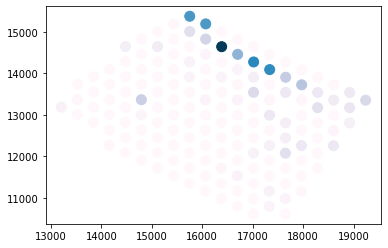

In [23]:
'Example: visualize spatial probability of cell type L6b'
plt.scatter(x=space_data.obs.x, y=space_data.obs.y, c=prob_assign['L6b'], s=100, cmap='PuBu');

**Deconvolution**

In [24]:
'Assign cell type to each spatial voxel'
# create a dataframe x, y, cell count for each voxel, and cell centroids for each voxel
df_vox_cells = pd.DataFrame({'x' : space_data.obs.x, 'y' : space_data.obs.y, 'cell_n' : space_data.obs.cell_count, 'centroids' : cells_positions})
# get the most probable voxel for each cell
resulting_voxels = np.argmax(output, axis=1)
# create a list with filtered cells and the voxels where they have been placed with the 
#highest probability a cell i is filtered if F_i > 0.5'
filtered_voxels_to_types = [(j, adata.obs.subclass[k]) for i, j, k in zip(F_out, resulting_voxels, range(len(adata))) if i > 0.5]
filtered_voxels_to_types[:5]

For example: `[(109, 'Sst'), (96, 'Vip'), (33, 'Lamp5'), (44, 'Sst'), (102, 'Pvalb')]`
means that voxel 109 has a cell _Sst_, voxel 96 has a cell _Vip_, and so on. The length of `filtered_voxels_to_types` is equal to the number of mapped cells.

In [28]:
'Create a dataframe with the number of cell types in each voxel'
for index, i in enumerate(df_classes.columns):
    df_vox_cells[i] = 0
for k, v in filtered_voxels_to_types:
    df_vox_cells.iloc[k, df_vox_cells.columns.get_loc(v)] += 1

In [29]:
df_vox_cells.head()

,x,y,cell_n,centroids,L4,Vip,Lamp5,L5 NP,Sst,L5 IT,...,Astro,L5 PT,L6b,Endo,Peri,Meis2,Macrophage,CR,VLMC,SMC
CGCTGTGACGCCGCAC-1,13204,13187,1,"[[833, 826]]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ATGCACTACCGCATTG-1,13838,12820,4,"[[802, 869], [810, 869], [811, 874], [812, 869]]",0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
CAGATACTAACATAGT-1,13521,13003,4,"[[816, 852], [818, 851], [821, 852], [823, 854]]",0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
GATCGACACTATCTGA-1,13839,13185,5,"[[828, 874], [829, 870], [831, 868], [833, 876...",0,6,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1
ATAGAGTACTGGGACA-1,13522,13368,3,"[[836, 850], [836, 854], [845, 855]]",1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [30]:
'Assign cell types to coordinates'
cell_types_mapped = mapping.utils.df_to_cell_types(df_vox_cells, list(df_classes.columns))

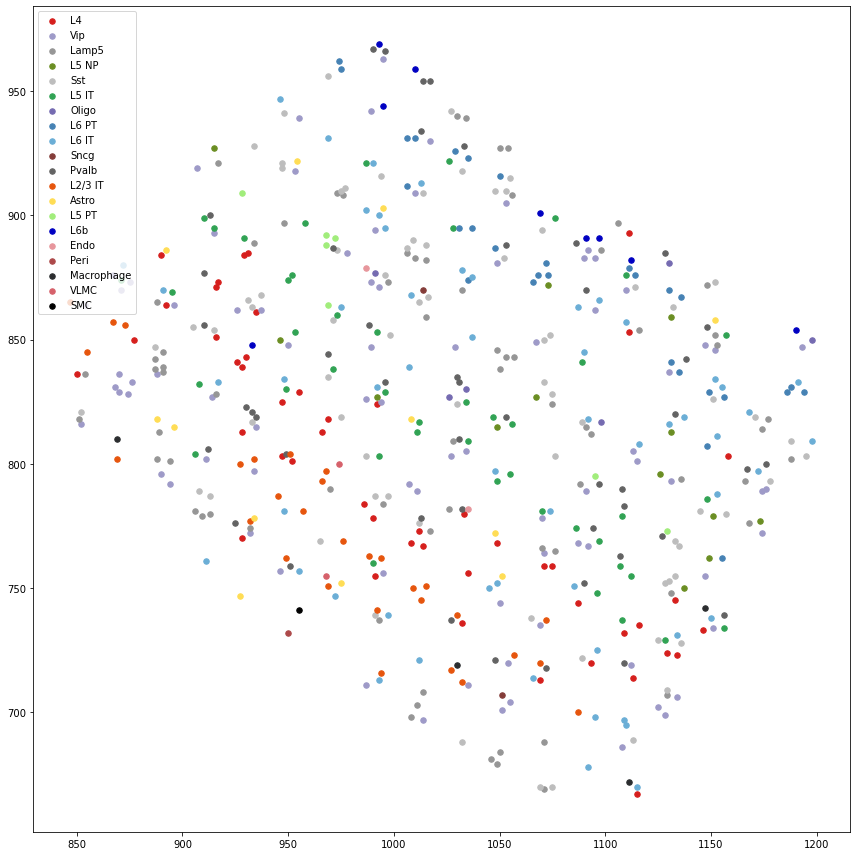

In [31]:
'Visualize all cells, using the colormap in the library'

plt.figure(figsize = (12,12))

for index, (k,v) in enumerate(cell_types_mapped.items()):
    if len(v) == 0:
        continue
    x_cells, y_cells = zip(*v)
    plt.scatter(y_cells, x_cells, s= 30, label=k, color=mapping.plot_utils.mapping_colors[k])
    
s_area = ((space_data.uns['spot_diameter_fullres']*space_data.uns['tissue_hires_scalef'])/2)**2
s_area_pixels = s_area * 1.38

plt.legend(loc='upper left')
plt.tight_layout()

#plt.savefig('all_types.png', dpi=300)